# Lecture 05 - Unit Roots and Stationarity, ARMA and GARCH models

In [ ]:
#%pip install arch

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import pandas_datareader.data as web

import statsmodels
# we will use `smf` and `sm` to constract and estimate same regressions but using different ways
import statsmodels.formula.api as smf  
import statsmodels.api as sm
import statsmodels.stats.api as sms
from patsy import dmatrices
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set_style('darkgrid')
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font",family="sans-serif")
plt.rc("font",size=14)

# Install `arch` library from Anaconda Prompt by executing:
# conda install arch -c bashtage
# OR from your Notebook:
# %pip install arch
from arch.univariate import arch_model, ARX, ARCH, GARCH, StudentsT
import arch.data.sp500


### Random number generator

A **white noise** signal (process) is constituted by a set of independent and identically distributed (**i.i.d.**) random variables. 
- In discrete sense, the white noise signal constitutes a series of samples that are independent and generated from the same probability distribution. 
- For example, you can generate a white noise signal using a random number generator in which all the samples follow a given Gaussian distribution. This is called White Gaussian Noise (WGN) or Gaussian White Noise. 

Similarly, a white noise signal generated from a Uniform distribution is called Uniform White Noise. White Gaussian Noise and Uniform White Noise are frequently used in system modelling. In modelling/simulation, a white noise can be generated using an appropriate random generator. White Gaussian Noise can be generated using one of the randomizers in Python which generates random numbers that follow a Gaussian distribution. Similarly, functions can be used to generate Uniform White Noise that follows a uniform distribution.  

More information on numpy's random module __[here](https://docs.scipy.org/doc/numpy-1.16.0/reference/routines.random.html)__.

In [2]:
# Generate a vector of 10 random variables with mean=0 and variance=1:
np.random.normal(size = (10,1), loc = 0.0, scale = 1)  

array([[ 0.02312113],
       [-1.4340872 ],
       [-0.06540362],
       [-1.30377348],
       [ 0.1185837 ],
       [-1.38188451],
       [-1.72176427],
       [-1.40710627],
       [-0.05757819],
       [ 1.12031856]])

### Generating data

In [3]:
nObs = 1000                                   # Number of observations
mu = 4                                        # Mean
sigma = 3                                     # Volatility

In [4]:
# Using standard normal distribution:
noise = sigma * np.random.randn(nObs,1) + mu  # White Gaussian noise
print(f'nRows: {noise.shape[0]}. nCol: {noise.shape[1]}. Mean: {np.mean(noise):.8f} and StDev: {np.std(noise):.8f}.')

nRows: 1000. nCol: 1. Mean: 3.89332934 and StDev: 3.09826661.


In [5]:
# Using normal distribution:
noise = np.random.normal(size = (nObs,1), loc = mu, scale = sigma) 
print(f'nRows: {noise.shape[0]}. nCol: {noise.shape[1]}. Mean: {np.mean(noise):.8f} and StDev: {np.std(noise):.8f}.')

nRows: 1000. nCol: 1. Mean: 4.11476920 and StDev: 3.06374261.


In [6]:
nObs = 1000
mu = 0
sigma = 3

# Proxy for stock returns
x=np.random.normal(size = (nObs,1), loc = mu, scale = sigma)

# Proxy fro stock prices  (cumulated from random s"stock returns")
X=np.cumsum(x)

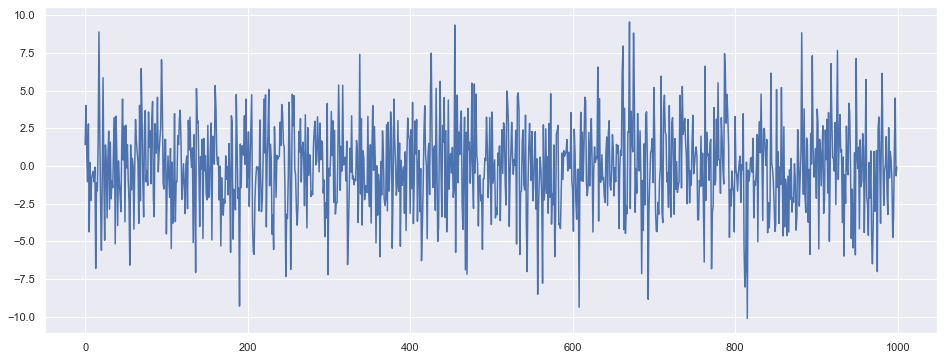

In [7]:
plt.plot(x); # Try plotting X instead of x

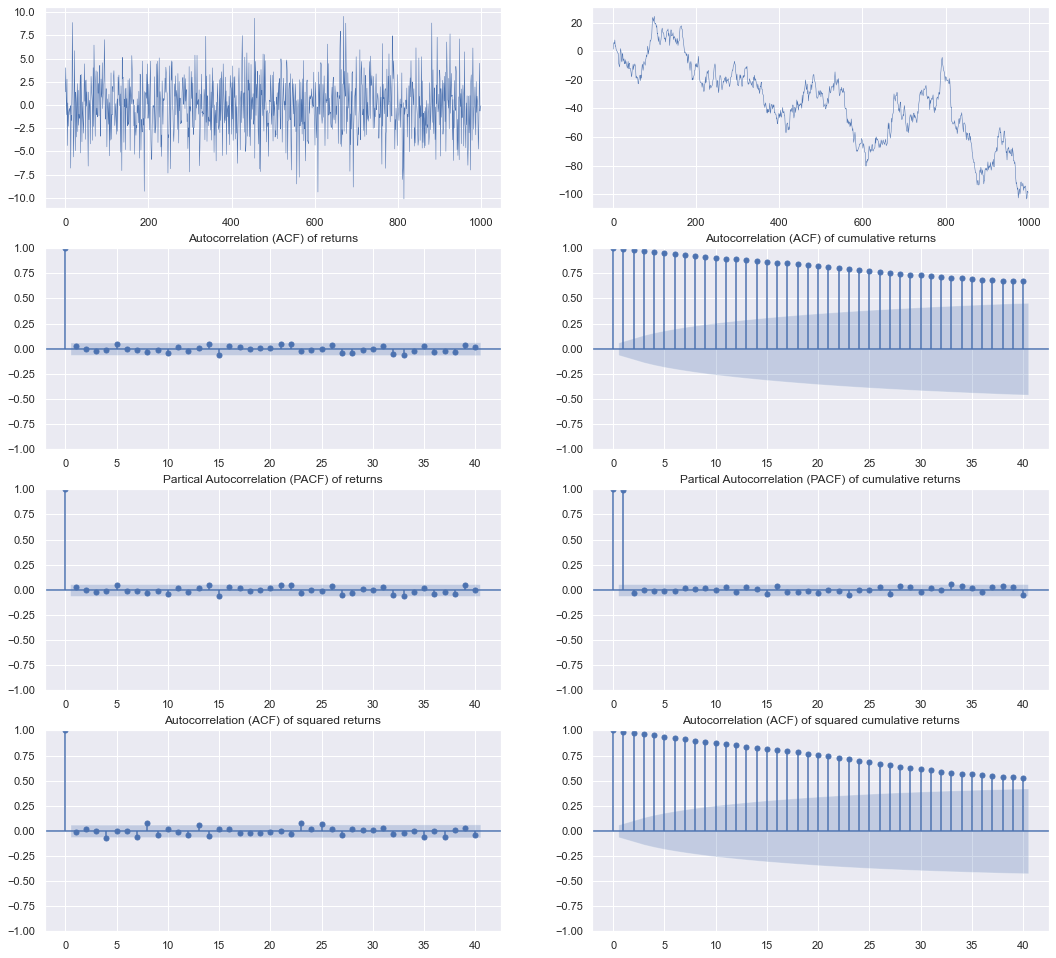

In [8]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(18,17))
nLags=40
a=0.05

ax[0,0].plot(x, linewidth=0.5, alpha=1)
ax[0,1].plot(X, linewidth=0.5, alpha=1)
sm.graphics.tsa.plot_acf(x, 
                         lags=nLags, alpha=a, 
                         title="Autocorrelation (ACF) of returns",
                         ax=ax[1,0])
sm.graphics.tsa.plot_acf(X, 
                         lags=nLags, alpha=a, 
                         title="Autocorrelation (ACF) of cumulative returns",
                         ax=ax[1,1])
sm.graphics.tsa.plot_pacf(x, 
                         lags=nLags, alpha=a, 
                         title="Partical Autocorrelation (PACF) of returns", method='ywm',
                         ax=ax[2,0])
sm.graphics.tsa.plot_pacf(X, 
                         lags=nLags, alpha=a, 
                         title="Partical Autocorrelation (PACF) of cumulative returns", method='ywm',
                         ax=ax[2,1])
sm.graphics.tsa.plot_acf(x**2, 
                         lags=nLags, alpha=a, 
                         title="Autocorrelation (ACF) of squared returns",
                         ax=ax[3,0])
sm.graphics.tsa.plot_acf(X**2, 
                         lags=nLags, alpha=a, 
                         title="Autocorrelation (ACF) of squared cumulative returns",
                         ax=ax[3,1])
plt.show()

In [9]:
# Helper function to automate some of the functionality:

def plot_TS(x,nlags,a):
    # x     : data
    # nlags : number of lags to consider
    # a     : significance level
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14,16))
    ax[0].plot(x, linewidth=0.5, alpha=1)
    ax[0].set_title("Data")
    sm.graphics.tsa.plot_acf(x, 
                         lags=nLags, alpha=a, 
                         title="Autocorrelation (ACF)",
                         ax=ax[1])
    sm.graphics.tsa.plot_pacf(x, 
                         lags=nLags, alpha=a, method="ywm",
                         title="Partical Autocorrelation (PACF)",
                         ax=ax[2])
    plt.show()

> ### <font color=red>Homework</font>:
> Improve the function above to include default values for `nlags` and `a`.

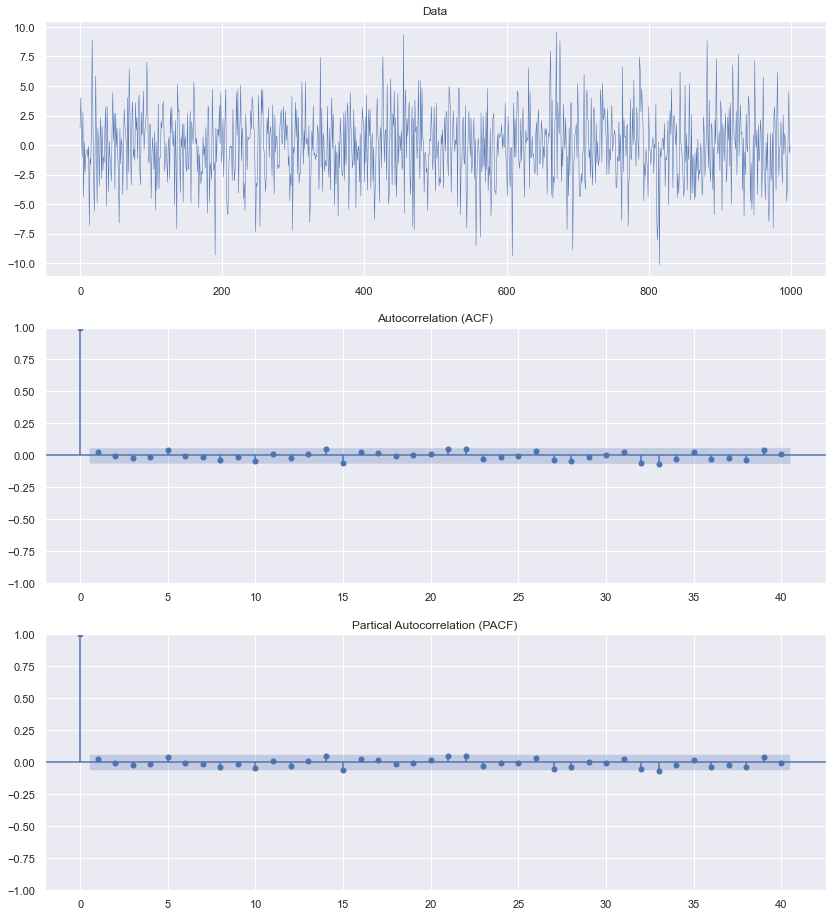

In [10]:
plot_TS(x,40,0.05) # try X instead of x

## Nelson-Plosser dataset

Macroeconomic series of Nelson and Plosser  
Dates: Annual, 1860 to 1970  
Series:
1. (GNPR) Real GNP, billions of 1958 dollars 
2. (GNPN) Nominal GNP, millions of current dollars 
3. (GNPPC) Real per capita GNP, 1958 dollars       
4. (IPI) Industrial production index, 1967 = 100 
5. (E) Total employment, thousands          
6. (UR) Total unemployment rate, percent 
7. (GNPD) GNP deflator, 1958 = 100      
8. (CPI) Consumer price index, 1967 = 100   
9. (WN) Nominal wages, current dollars 
10. (WR) Real wages, WN/CPI                
11. (MS) Money stock, billions of dollars  
12. (MV) Velocity of money, (Nominal GDP)/MS 
13. (BY) Bond yield, percent per annum  
14. (SP) Stock price index             
    
Reference:
> Nelson, C. R., and C. I. Plosser. "Trends Versus Versus Random Walks in Macroeconomic Time Series: Some Evidence and Implications." Journal of Monetary Economics. Vol. 10, 1982, pp. 139-162.                                     '



In [13]:
df = pd.read_csv('data/Data_NelsonPlosser.csv')
df

,Date,GNPR,GNPN,GNPPC,IPI,E,UR,GNPD,CPI,WN,WR,MS,MV,BY,SP
0,1860,NaN,NaN,NaN,0.9,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1861,NaN,NaN,NaN,0.9,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1862,NaN,NaN,NaN,0.9,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1863,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1864,NaN,NaN,NaN,1.0,NaN,NaN,NaN,48.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1966,658.1,750.0,3349.0,98.0,76018.0,3.8,113.9,97.2,6643.0,68.34,308.0,1.76,4.75,85.26
107,1967,675.2,794.0,3399.0,100.0,77818.0,3.8,117.6,100.0,6880.0,68.80,331.8,1.72,4.95,91.93
108,1968,706.6,864.0,3522.0,105.8,79455.0,3.6,122.3,104.2,7347.0,70.51,361.6,1.72,5.93,98.70
109,1969,724.7,929.0,3577.0,110.7,81408.0,3.5,128.2,109.8,7775.0,70.81,385.2,1.73,6.54,97.84


In [14]:
df.index=pd.to_datetime(df['Date'],format='%Y', errors='coerce')
df.drop(columns=['Date'],inplace=True)
df

,GNPR,GNPN,GNPPC,IPI,E,UR,GNPD,CPI,WN,WR,MS,MV,BY,SP
Date,,,,,,,,,,,,,,
1860-01-01,NaN,NaN,NaN,0.9,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN
1861-01-01,NaN,NaN,NaN,0.9,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN
1862-01-01,NaN,NaN,NaN,0.9,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN
1863-01-01,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.0,NaN,NaN,NaN,NaN,NaN,NaN
1864-01-01,NaN,NaN,NaN,1.0,NaN,NaN,NaN,48.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966-01-01,658.1,750.0,3349.0,98.0,76018.0,3.8,113.9,97.2,6643.0,68.34,308.0,1.76,4.75,85.26
1967-01-01,675.2,794.0,3399.0,100.0,77818.0,3.8,117.6,100.0,6880.0,68.80,331.8,1.72,4.95,91.93
1968-01-01,706.6,864.0,3522.0,105.8,79455.0,3.6,122.3,104.2,7347.0,70.51,361.6,1.72,5.93,98.70


There are 14 variables (columns). Extract a single variable and trim NaNs:

In [15]:
x=df['IPI'].dropna()
x

Date
1860-01-01      0.9
1861-01-01      0.9
1862-01-01      0.9
1863-01-01      1.0
1864-01-01      1.0
              ...  
1966-01-01     98.0
1967-01-01    100.0
1968-01-01    105.8
1969-01-01    110.7
1970-01-01    106.7
Name: IPI, Length: 111, dtype: float64

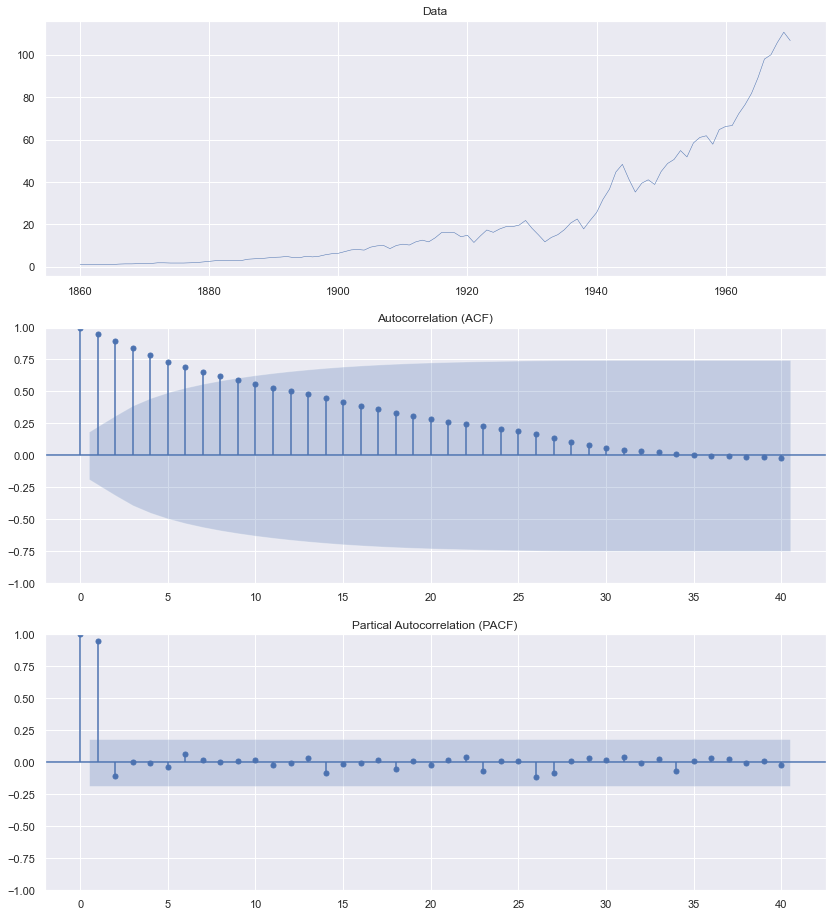

In [16]:
plot_TS(x,40,0.05)

- If ACF plot above shows gradual decay, that means that the variable is autocorrelated. 
- Often, including a lagged variable will mitigate autocorrelation in the errors.
- PACF can help us determine how many lags of the variables are to be included. Check for the number of first significant variables.
- Typically, for financial time series, you will observe a single significant value at lag 1 (lag 0 will always be significant). This would imply that, for a non-stationary series, it might be advisable to take the first difference of the series, in an attempt to convert it to stationary.

In [17]:
np.diff(np.log(x))

array([ 0.        ,  0.        ,  0.10536052,  0.        ,  0.        ,
        0.18232156,  0.08004271,  0.        ,  0.07410797,  0.06899287,
        0.        ,  0.18232156,  0.        , -0.05715841,  0.        ,
        0.        ,  0.05715841,  0.05406722,  0.14660347,  0.12783337,
        0.11332869,  0.06899287,  0.        , -0.03390155,  0.        ,
        0.18805223,  0.05556985,  0.02666825,  0.07598591,  0.07061757,
        0.02247286,  0.06453852, -0.1100009 , -0.0235305 ,  0.15415068,
       -0.0631789 ,  0.0631789 ,  0.13353139,  0.08552217,  0.03226086,
        0.11954515,  0.10676798,  0.0250013 , -0.03774033,  0.16507975,
        0.0631789 ,  0.02020271, -0.16251893,  0.16251893,  0.05826891,
       -0.03846628,  0.13720112,  0.0661398 , -0.0661398 ,  0.15048095,
        0.16874948,  0.00619197, -0.01242252, -0.12641392,  0.04845238,
       -0.26101383,  0.24053529,  0.17655785, -0.06569526,  0.09418722,
        0.05996346,  0.        ,  0.03636764,  0.1063804 , -0.18

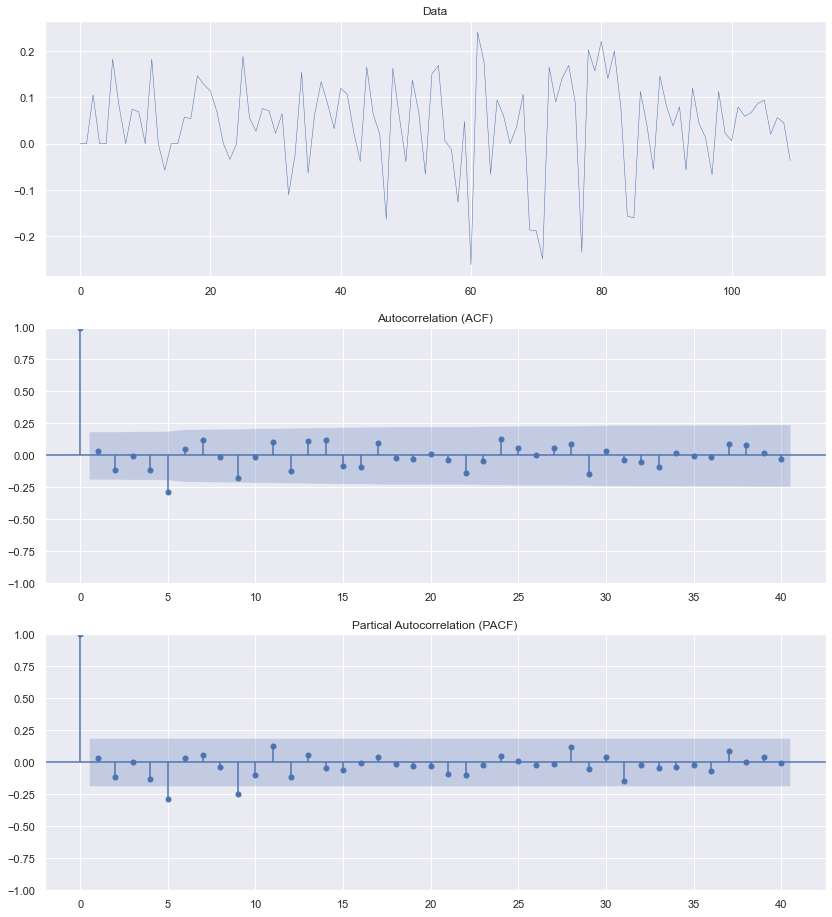

In [18]:
plot_TS(np.diff(np.log(x)),40,0.05)

## Unit Root tests

### Augmented Dickey-Fuller unit root test.
`adfuller(x,maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)`  

$H_0$: a unit root is present in a time series sample, aka series is non-stationary.  
$H_A$: different depending on which version of the test is used, but is usually stationarity or trend-stationarity.  

Model type:
`regression{‘c’,’ct’,’ctt’,’nc’}`
- `c` : constant only (default).
- `ct` : constant and trend.
- `ctt` : constant, and linear and quadratic trend.
- `nc` : no constant, no trend.
  
MY ADVICE: use `c` is no visible trend in the data and `ct` is there is a clear trend.  

Optimal lag selection:  
`autolag{‘AIC’, ‘BIC’, ‘t-stat’, None}` contols method for determining the optimal lag selection.
  
MY ADVICE: use `BIC` as it results in more stringent lag selection than `AIC`





In [19]:
x1=df['IPI'].dropna()
test=adfuller(x1,regression='c',autolag='BIC')
ADFpvalue=test[1]
print(ADFpvalue)

1.0


In [20]:
x2=np.diff(np.log(df['IPI'].dropna()))
test=adfuller(x2,regression='c',autolag='BIC')
ADFpvalue=test[1]
print(ADFpvalue)

2.259274811733373e-17


In [21]:
# Helper function to automate some of the functionality:

def ADFtest(x,a,modeltype,autolagcriterion):
    # x                : data
    # a                : significance level
    # modeltype        : model type
    # autolagcriterion : optimal lag selection method
    
    test=adfuller(x,regression=modeltype,autolag=autolagcriterion)
    print(f'Augmented Dickey-Fuller unit root test results:')
    print(f'\tTest statistics:\t\t {test[0]:9.4f}.')
    print(f'\tTest p-value:\t\t\t {test[1]:9.4f}.')
    print(f'\tNumber of lags selected:\t {test[2]:9.4f}.')
    if test[1]<=a:
        print('\tOUTCOME: Reject the null hypothesis. Series do not contain unit root.')
    else: 
        print('\tOUTCOME: Fail to reject the null hypothesis. Series appear to contain unit root.')

> ### <font color=red>Homework</font>:
> Improve the function above to include default values for `a`, `modeltype` and `autolagcriterion`.

In [22]:
ADFtest(x1,0.05,'c','AIC') # Try x2 as well

Augmented Dickey-Fuller unit root test results:
	Test statistics:		    4.4190.
	Test p-value:			    1.0000.
	Number of lags selected:	   11.0000.
	OUTCOME: Fail to reject the null hypothesis. Series appear to contain unit root.


### Kwiatkowski-Phillips-Schmidt-Shin test for stationarity.

Computes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null hypothesis that x is level or trend stationary.  

`kpss(x, regression='c', nlags=None, store=False)`  

$H_0$: the data is stationary (`c` around a constant ot `ct` around a trend).    
$H_A$: the data is non-stationary.  

Model type:
`regression{‘c’,’ct’}`
- `c` : constant only (default).
- `ct` : constant and trend.
  
MY ADVICE: use `c` is no visible trend in the data and `ct` is there is a clear trend.  

Optimal lag selection:  
`nlags{‘auto’, None}` contols method for determining the optimal lag selection.
  
MY ADVICE: use `auto`.

In [23]:
test=kpss(x1,regression='c',nlags='auto')
print(test)

(1.343043391141477, 0.01, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [24]:
def KPSStest(x,a,modeltype,autolagcriterion):
    test=kpss(x,regression=modeltype,nlags=autolagcriterion)
    print(f'Kwiatkowski-Phillips-Schmidt-Shin test for stationarity results:')
    print(f'\tTest statistics:\t\t {test[0]:9.4f}.')
    print(f'\tTest p-value:\t\t\t {test[1]:9.4f}.')
    print(f'\tNumber of lags selected:\t {test[2]:9.4f}.')
    if test[1]<=a:
        print('\tOUTCOME: Reject the null hypothesis. Series is non-stationary.')
    else: 
        print('\tOUTCOME: Fail to reject the null hypothesis. Series appear to be stationary.')

> ### <font color=red>Homework</font>:
> Improve the function above to include default values for `a`, `modeltype` and `autolagcriterion`.

In [25]:
KPSStest(x2,0.05,'c','auto')

Kwiatkowski-Phillips-Schmidt-Shin test for stationarity results:
	Test statistics:		    0.0397.
	Test p-value:			    0.1000.
	Number of lags selected:	    3.0000.
	OUTCOME: Fail to reject the null hypothesis. Series appear to be stationary.


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


> <font color=DeepPink>Exercise</font>: <br>
> The two tests, ADF and KPSS, have different null hypotheses:<br>
> - ADF's null hypothesis = series have unit root<br>
> - KPSS's null hypothesis = series are stationary<br>
> <br>
> What is the difference?

## ARMA models
Autoregressive Moving Average (ARMA) models.  
Autoregressive integrated Moving Average (**ARIMA**) models.   

- The AR part of ARIMA indicates that the evolving variable of interest is regressed on its own lagged (i.e., prior) values. 
- The MA part indicates that the regression error is actually a linear combination of error terms whose values occurred contemporaneously and at various times in the past (error terms from the past periods still affect current values of the variable).  
- The I (for "integrated") indicates that the data values have been replaced with the difference between their values and the previous values (and this differencing process may have been performed more than once). The purpose of each of these features is to make the model fit the data as well as possible.  

ARIMA models are generally denoted $ARIMA(p,d,q)$ where parameters $p$, $d$, and $q$ are non-negative integers, $p$ is the order (number of time lags) of the autoregressive model, $d$ is the degree of differencing (the number of times the data have had past values subtracted), and $q$ is the order of the moving-average model.  

If you have checked the dat for unit root and made sure it is stationary, you do not need to difference your data and you can use simplified notation, $ARIMA(p,0,q)=ARMA(p,q)$.  

<img src="figs/ARMAlags_ACF_PACF2.png" alt="Alt text that describes the graphic" title="Python data types" style="width: 400px;"/>


### Examples:
- $ARIMA(0, 1, 0)$ model, or simply $I(1)$ is given by $X_{t}=X_{t-1}+\varepsilon _{t}$ which is simply a random walk.
- $ARIMA(0, 1, 0)$ model with a constant, given by $X_{t}=c+ X_{t-1}+\varepsilon _{t}$ is a random walk with a drift.
- $ARIMA(0, 0, 0)$ model is a white noise model.


### Generate data

In [26]:
from statsmodels.tsa.arima_process import arma_generate_sample

In [27]:
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])

# The conventions of the arma_generate function require that we specify a 1 for the zero-lag of the AR and MA parameters and that the AR parameters be negated.
ar = np.r_[1, -arparams]
ma = np.r_[1, maparams]
nobs = 1000
y = arma_generate_sample(ar, ma, nobs, scale=0.1)

> ### <font color=red>Homework</font>:
> Generate time-series with different characteristics:<br>
> - Different number of AR parameters (none, 1, 2, 3, ...)
> - Different number of MA parameters (none, 1, 2, 3, ...)
> - Make sure that the sum of AR or MA parameters does not exceed 1. (<font color=red>What would happen if the sum of AR/MA parameters exceed 1? Try plotting it.)</font>

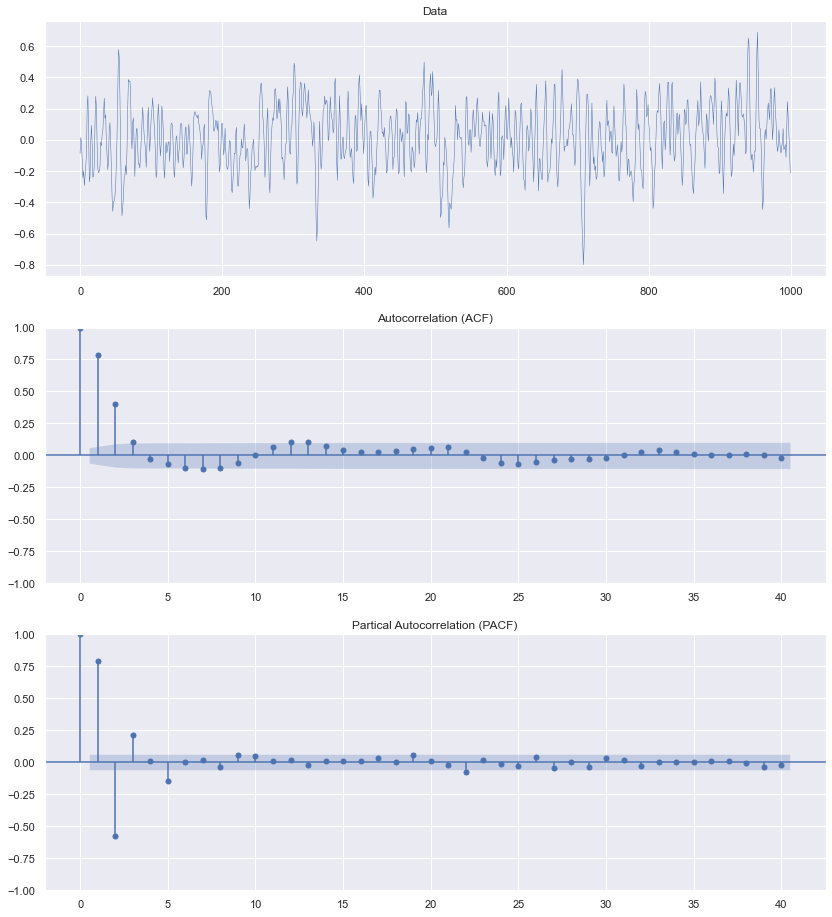

In [28]:
plot_TS(y,40,0.05)

In [29]:
arma_mod = sm.tsa.arima.ARIMA(y, order=(2,0,2),trend='n')
arma_res = arma_mod.fit()
arma_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 908.364
Date:                Sat, 26 Feb 2022   AIC                          -1806.727
Time:                        22:18:53   BIC                          -1782.188
Sample:                             0   HQIC                         -1797.401
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6702      0.084      7.968      0.000       0.505       0.835
ar.L2         -0.2132      0.065     -3.263      0.001      -0.341      -0.085
ma.L1          0.7070      0.079      8.957      0.000       0.552       0.862
ma.L2          0.3819      0.051      7.422      0.000       0.281       0.483
sigma2         0.0095      0.000     21.733      0.000       0.009       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.54
Prob(Q):                              0.94   Prob(JB):                         0.76
Heteroskedasticity (H):               1.14   Skew:                             0.02
Prob(H) (two-sided):                  0.23   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

> ### <font color=red>Homework</font>:
> Try estimating ARIMA model of `order=(2,0,0)` instead in the above and watch **Ljung-Box** statistic and p-value.:<br>
> - What do you observe?
> - Why is this happening?

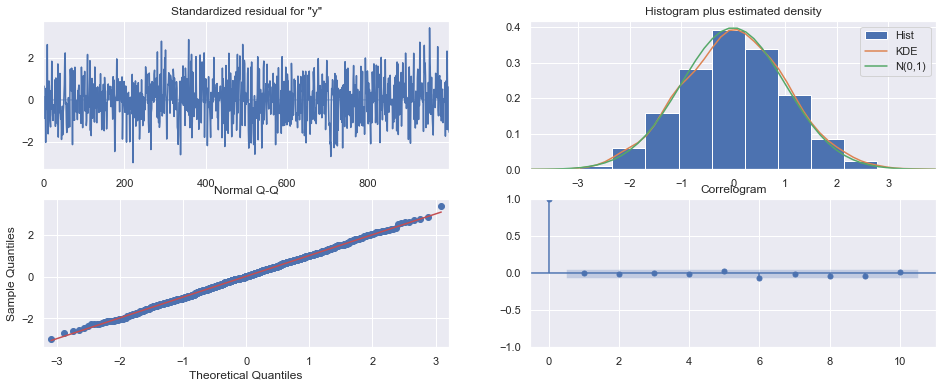

In [30]:
arma_res.plot_diagnostics();

In [31]:
def simulateARMA(arparams,maparams,nobs,sigma):
    arparams = np.array(arparams)
    maparams = np.array(maparams)
    # The conventions of the arma_generate function require that we specify a 1 for the zero-lag of the AR and MA parameters and that the AR parameters be negated.
    ar = np.r_[1, -arparams]
    ma = np.r_[1, maparams]
    y = arma_generate_sample(ar, ma, nobs, scale=sigma)
    return y

#### Pure MA(q) models

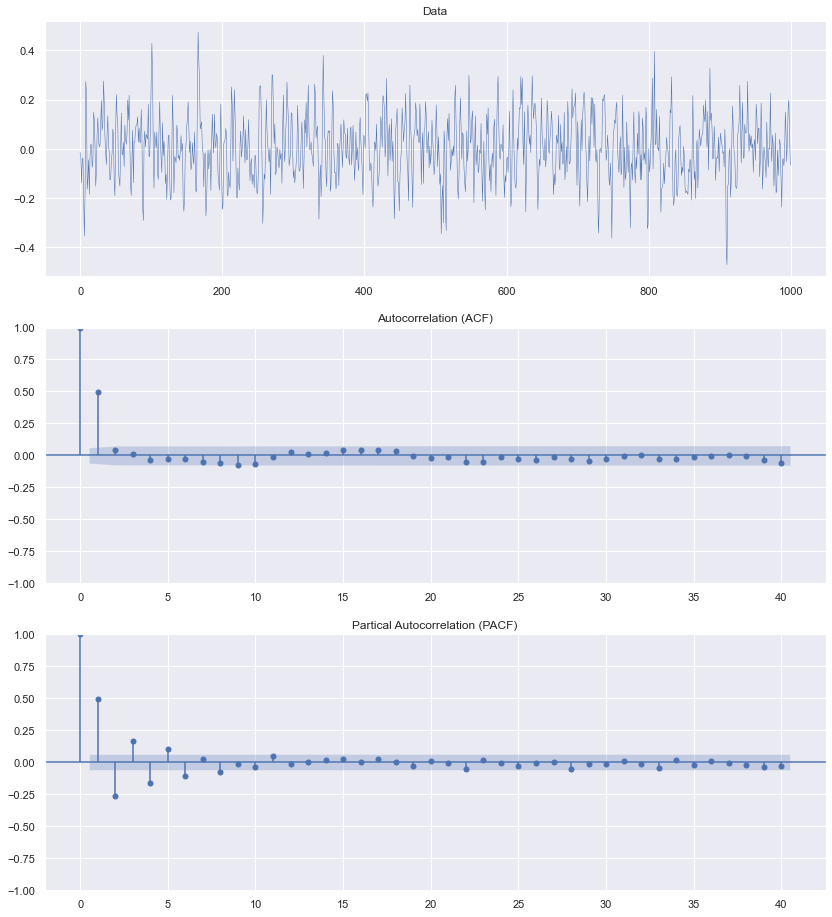

In [32]:
y=simulateARMA([],[0.7],1000,0.1)
plot_TS(y,40,0.05)

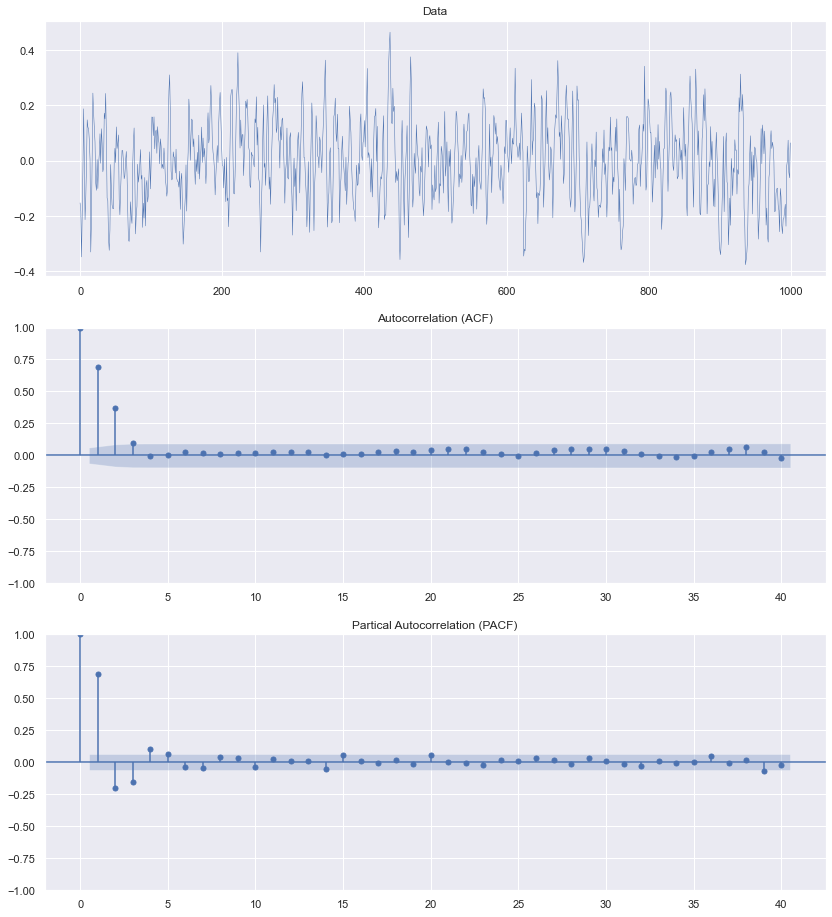

In [33]:
y=simulateARMA([],[0.8,0.6,0.2],1000,0.1)
plot_TS(y,40,0.05)

#### Pure AR(p) models

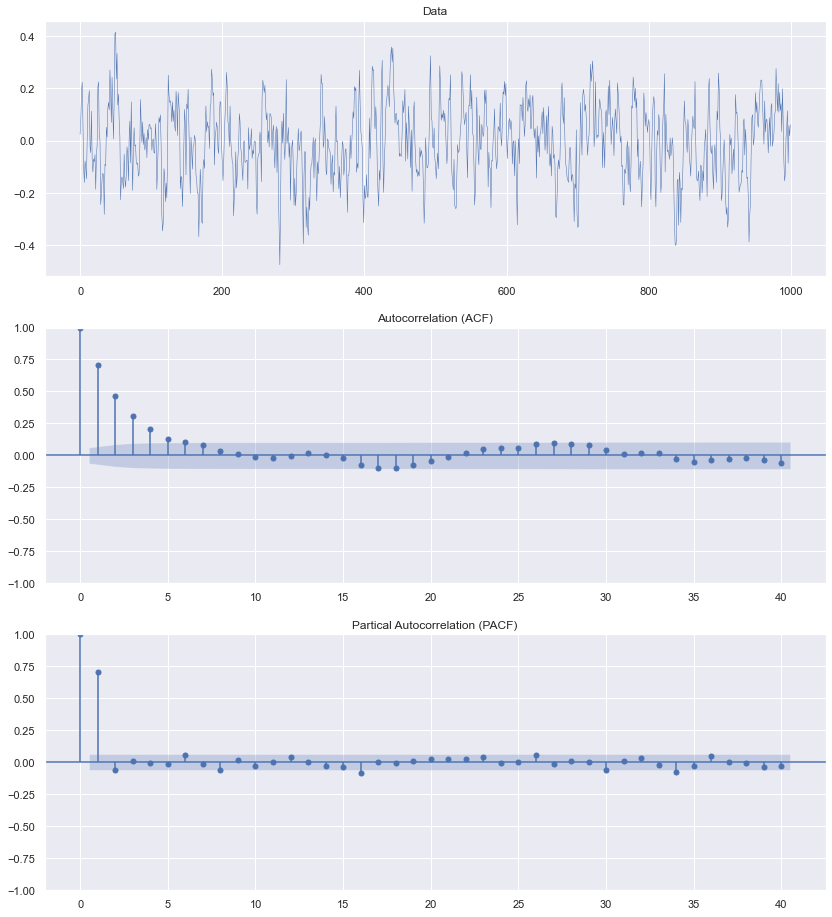

In [34]:
y=simulateARMA([0.7],[],1000,0.1)
plot_TS(y,40,0.05)

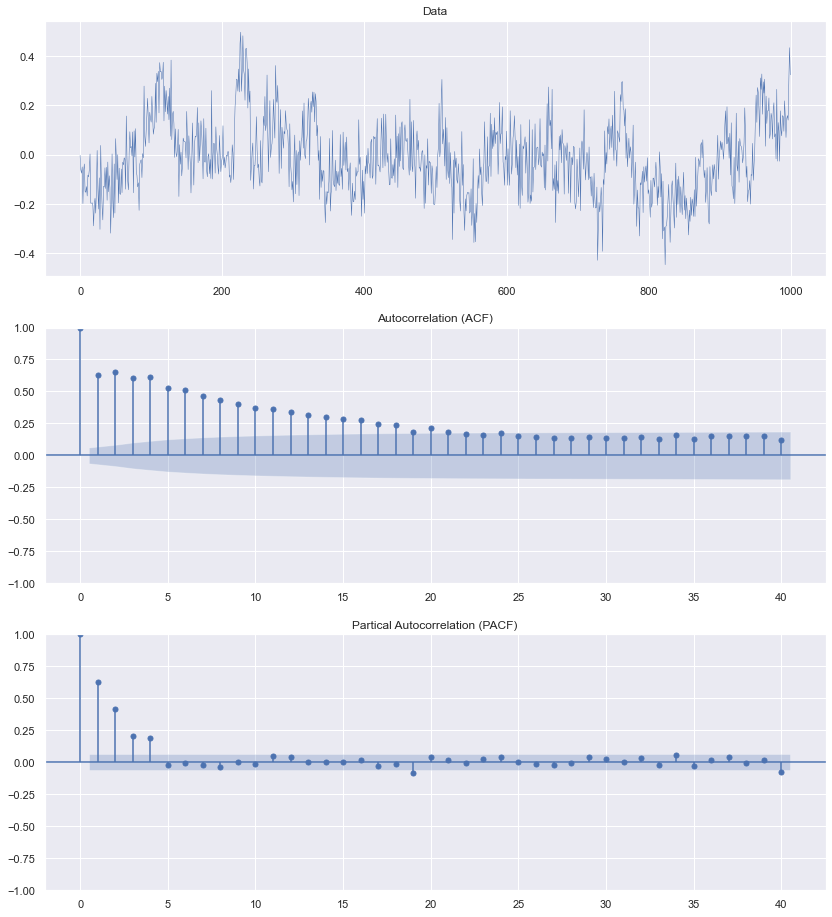

In [35]:
y=simulateARMA([0.3, 0.28, 0.20, 0.15],[],1000,0.1)
plot_TS(y,40,0.05)

#### ARMA (p,q) models

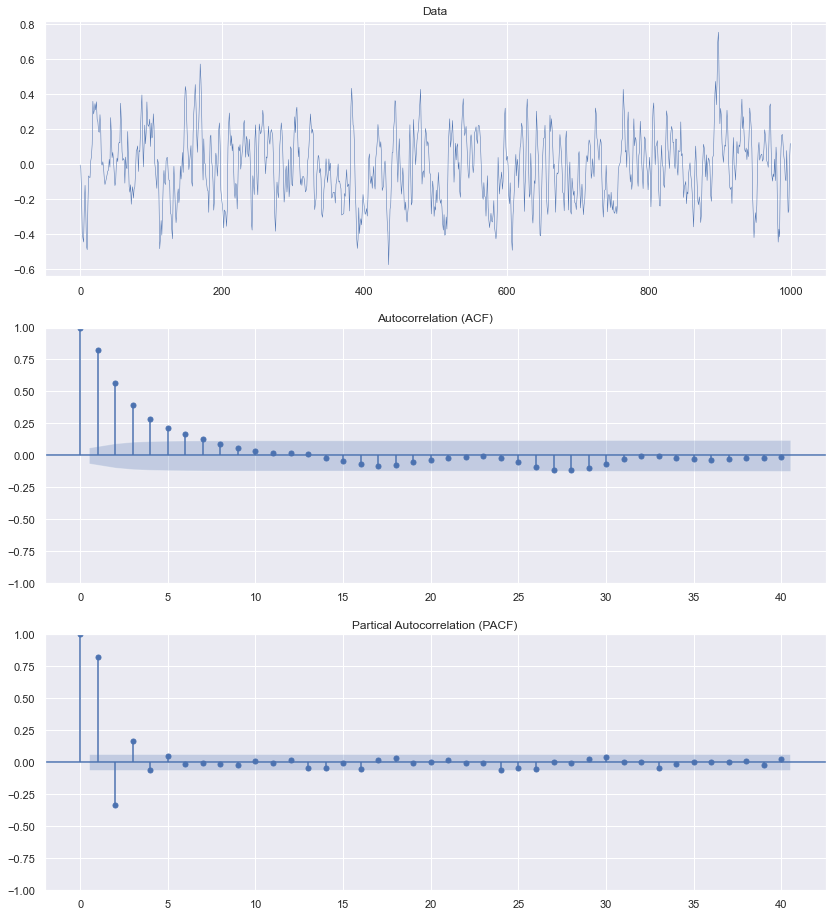

In [36]:
y=simulateARMA([0.7],[0.5],1000,0.1)
plot_TS(y,40,0.05)

In [37]:
arma_mod = sm.tsa.arima.ARIMA(y, order=(1,0,1),trend='n') 
# Try "incorrect" ARMA(p,q) orders, e.g., q=0 or p=0.
# Observe diagnostics and AIC/BIC values

model_fit = arma_mod.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 859.810
Date:                Sat, 26 Feb 2022   AIC                          -1713.619
Time:                        22:19:05   BIC                          -1698.896
Sample:                             0   HQIC                         -1708.023
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6912      0.025     27.199      0.000       0.641       0.741
ma.L1          0.4763      0.030     16.139      0.000       0.418       0.534
sigma2         0.0105      0.000     21.777      0.000       0.010       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.56
Prob(Q):                              0.97   Prob(JB):                         0.02
Heteroskedasticity (H):               0.97   Skew:                             0.21
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

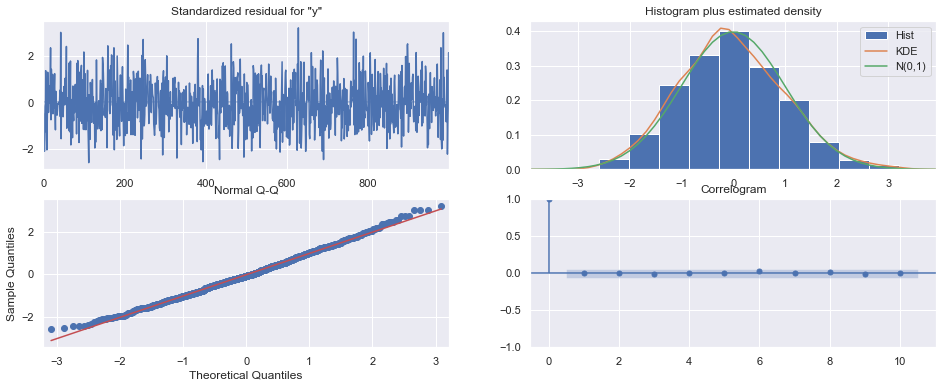

In [38]:
model_fit.plot_diagnostics();

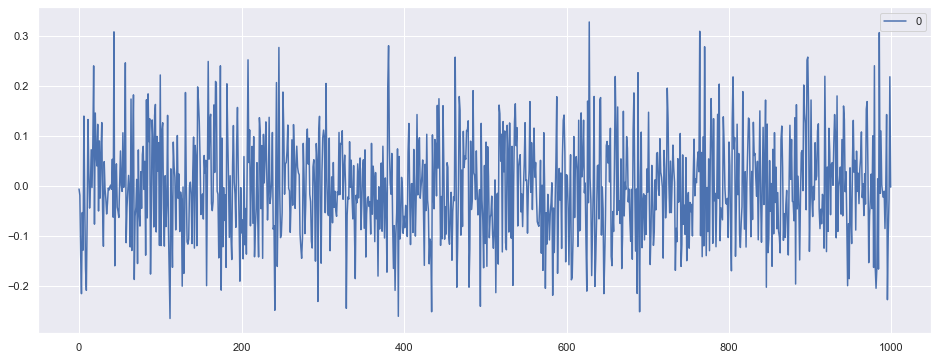

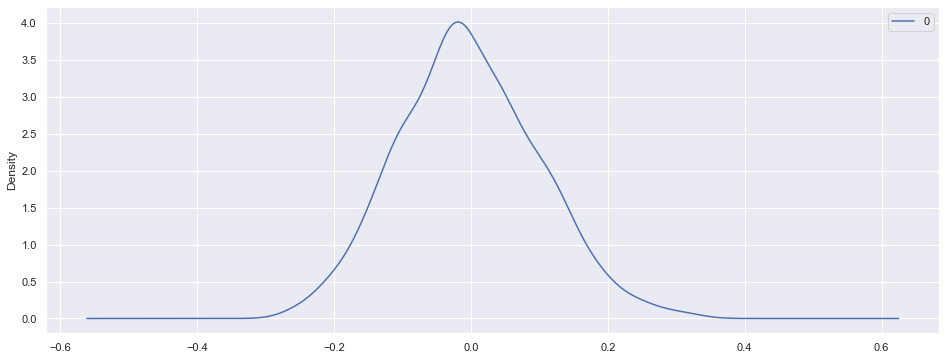

                 0
count  1000.000000
mean     -0.003123
std       0.102345
min      -0.264830
25%      -0.074940
50%      -0.008651
75%       0.064139
max       0.328252


In [39]:
# Analyse and plot residual error:

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Rolling Forecast ARIMA Model

Example 1:<img src="figs/periodic_VS_rolling_sampling.jpg" alt="Alt text that describes the graphic" title="" style="width: 600px;"/>

Example 2:<img src="figs/rolling_forecast.svg" alt="Alt text that describes the graphic" title="" style="width: 600px;"/>


- The ARIMA model can be **used to forecast** series at future time steps.  
- We can use the `predict()` function on the ARIMAResults object to make predictions. 
    - It accepts the index of the time steps to make predictions as arguments. 
    - These indexes are relative to the start of the training dataset used to make predictions. For example, if we used 100 observations in the training dataset to fit the model, then the index of the next time step for making a prediction would be specified to the prediction function as `start=101`, `end=101`. This would return an array with one element containing the prediction.  
- We also would prefer the forecasted values to be in the original scale, in case we performed any differencing (d>0 when configuring the model). This can be specified by setting the `typ` argument to the value ‘levels’: `typ=’levels’`.  
- Alternately, we can avoid all of these specifications by using the forecast() function, which performs a one-step forecast using the model.  
- We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.  
- A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.  
- We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.  

Putting this all together, below is an example of a rolling forecast with the **ARIMA model** in Python.

In [40]:
X=simulateARMA([0.9],[],300,0.1)
X.shape

(300,)

In [41]:
split_size = int(len(X) * 0.66)
train, test = X[0:split_size], X[split_size+1:len(X)]
history = [x for x in train]
predictions = list()
ci_l = list()
ci_u = list()

Try the code snippet below to see how forecast functionality works:

In [42]:
model = sm.tsa.arima.ARIMA(history, order=(1,0,0),trend='n') 
model_fit = model.fit()
output= model_fit.get_forecast(steps=1).summary_frame()
output

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,0.185523,0.105961,-0.022157,0.393203


In [43]:
output.iloc[0,2] # Use .iloc or column name to refer to specific elements in Pandas DataFrame

-0.02215650100134775

In [44]:
# for each observation in the TEST data set do 
for t in range(len(test)):
    # estimate ARMA model
    model = sm.tsa.arima.ARIMA(history, order=(1,0,0),trend='n') # Try forecasting with the WRONG model
    model_fit = model.fit()
    
    # forecast 1 step ahead
    output= model_fit.get_forecast(steps=1).summary_frame()
    
    # save the output
    yhat = output.iloc[0,0]    # your single predicted value from the model
    predictions.append(yhat)   # ever growing list of predicted values
    obs = test[t]              # your single actual value taken from the TEST data
    ci_l.append(output.iloc[0,2])    # CIs for the prediction (growing set)
    ci_u.append(output.iloc[0,3])
    print('predicted=%f, expected=%f, length of history=%f' % (yhat, obs, len(history)))
    
    # Remove the first observation in the training set (history)
    # If active: rolling window, 
    # If inactive: expanding window.
    history.pop(0) # see exlplanation right above
    
    history.append(obs)       # ever growing list of actual values - these are the same as TEST data

predicted=0.185523, expected=0.111192, length of history=198.000000
predicted=0.099191, expected=0.317710, length of history=198.000000
predicted=0.284048, expected=0.378496, length of history=198.000000
predicted=0.341104, expected=0.291490, length of history=198.000000
predicted=0.261765, expected=0.120793, length of history=198.000000
predicted=0.108107, expected=0.140860, length of history=198.000000
predicted=0.125853, expected=0.175330, length of history=198.000000
predicted=0.157137, expected=-0.024295, length of history=198.000000
predicted=-0.021659, expected=0.081851, length of history=198.000000
predicted=0.073263, expected=0.197043, length of history=198.000000
predicted=0.177635, expected=0.106103, length of history=198.000000
predicted=0.095223, expected=0.063959, length of history=198.000000
predicted=0.057144, expected=0.052996, length of history=198.000000
predicted=0.047652, expected=-0.027434, length of history=198.000000
predicted=-0.024402, expected=-0.149396, leng

In [45]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 0.011


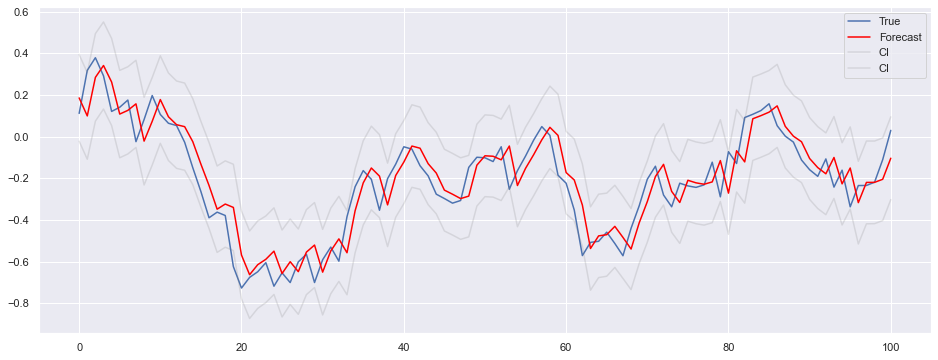

In [46]:
# plot
plt.plot(test,label="True")
plt.plot(predictions, color='red', label="Forecast")
plt.plot(ci_u, color='grey', label="CI",alpha=0.2)
plt.plot(ci_l, color='grey', label="CI",alpha=0.2)
plt.legend()
plt.show()


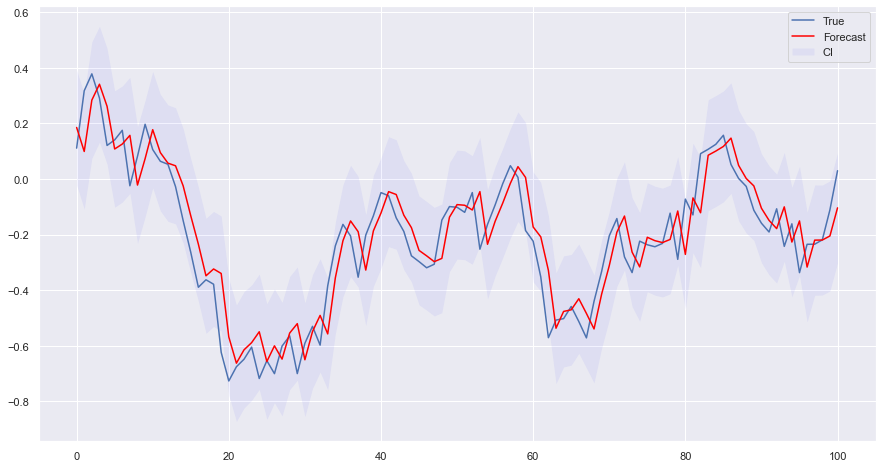

In [47]:
fig, ax = plt.subplots(figsize=(15,8))

plt.plot(test,label="True")
plt.plot(predictions, color='red', label="Forecast")

# Plot CI as a filled region between ci_l and ci_u
ax = plt.gca()      # get axis handle (you can omit it if you used "fig, ax = plt.subplots" above)
line = ax.lines[0]  # get the first line, there might be more
x=line.get_xdata()  # get x data from the plot itself
#print(x)
plt.fill_between(x, ci_l,ci_u, facecolor='blue', label="CI",alpha=0.05)

plt.legend()
plt.show()

# Volatility modeling

- Autoregressive models can be developed for univariate time series data that is stationary (**AR**), has a trend (**ARIMA**), and has a seasonal component (**SARIMA**). One aspect of a univariate time series that these autoregressive models **do not model is a change in the variance over time**.  
- Classically, a time series with modest changes in variance can sometimes be adjusted using a power transform, such as by taking the Log or using a Box-Cox transform.  
- There are some time series where the **variance changes consistently over time**. In the context of a time series in the financial domain, this would be called increasing and decreasing volatility.  
- In time series where the **variance is increasing in a systematic way**, such as an increasing trend, this property of the series is called heteroskedasticity.  
- If the change in variance can be correlated over time, then it can be modeled using an autoregressive process, such as **ARCH**.  

## What Is an ARCH Model?

Autoregressive Conditional Heteroskedasticity, or ARCH, is a method that explicitly models the change in variance over time in a time series. Specifically, an ARCH method models the variance at a time step as a function of the residual errors.  

A lag parameter must be specified to define the number of prior residual errors to include in the model. We can refer to this parameter as $q$, the number of lag squared residual errors to include in the ARCH model. A generally accepted notation for an ARCH model is to specify the ARCH() function with the $q$ parameter $ARCH(q)$; for example, $ARCH(1)$ would be a first order ARCH model.  

The approach expects the series is stationary, other than the change in variance, meaning it does not have a trend or seasonal component. In practice, this can be used to model the expected variance on the residuals after another autoregressive model has been used, such as an ARMA or similar.  


## What Is a GARCH Model?

Generalized Autoregressive Conditional Heteroskedasticity, or GARCH, is an extension of the ARCH model that incorporates a moving average component together with the autoregressive component. Specifically, the model includes lag variance terms (e.g. the observations if modeling the white noise residual errors of another process), together with lag residual errors from a mean process.

The introduction of a moving average component allows the model to both model the conditional change in variance over time as well as changes in the time-dependent variance. Examples include conditional increases and decreases in variance.  

As such, the model introduces a new parameter $p$ that describes the number of lag variance terms:
- p: The number of lag variances to include in the GARCH model.
- q: The number of lag residual errors to include in the GARCH model.

A generally accepted notation for a GARCH model is to specify the GARCH() function with the $p$ and $q$ parameters $GARCH(p, q)$; for example $GARCH(1, 1)$ would be a first order GARCH model.  

A GARCH model subsumes ARCH models, where a GARCH(0, q) is equivalent to an ARCH(q) model. For $p = q = 0$ the process is simply [white noise](https://en.wikipedia.org/wiki/White_noise).  

As with ARCH, GARCH predicts the future variance and expects that the series is stationary, other than the change in variance, meaning it does not have a trend or seasonal component.  

## How to Configure ARCH and GARCH Models (aka find $p$ and $q$ values)

- The configuration for an ARCH model is best understood in the context of ACF and PACF plots of the variance of the time series. 
- This can be achieved by subtracting the mean from each observation in the series (**de-meaning**) and squaring the result. 
- The ACF and PACF plots can then be interpreted to estimate values for $p$ and $q$, in a similar way as is done for the ARMA model.

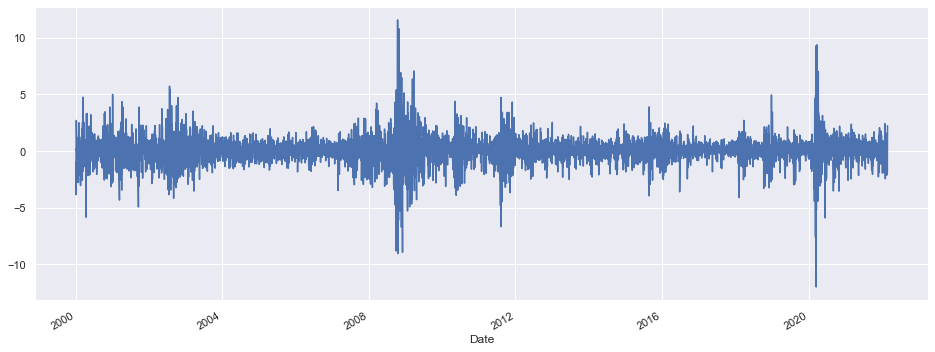

In [48]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2022, 2, 25)
sp500 = web.DataReader('^GSPC', 'yahoo', start=start, end=end)
returns = 100 * sp500['Adj Close'].pct_change().dropna()
fig=returns.plot()

A basic GARCH(1,1) with a constant mean can be constructed using only the return data:

In [49]:
am = arch_model(returns)
res=am.fit() # use option update_freq=5 where 5 is step of output iteration to display
res.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 863480996.0502331
Iteration:      2,   Func. Count:     15,   Neg. LLF: 167877448.07579592
Iteration:      3,   Func. Count:     22,   Neg. LLF: 10803.904585997025
Iteration:      4,   Func. Count:     29,   Neg. LLF: 7793.014608689355
Iteration:      5,   Func. Count:     35,   Neg. LLF: 7665.49841393689
Iteration:      6,   Func. Count:     41,   Neg. LLF: 7834.784011575779
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7643.849850285003
Iteration:      8,   Func. Count:     52,   Neg. LLF: 7644.025781843733
Iteration:      9,   Func. Count:     58,   Neg. LLF: 7643.809322872128
Iteration:     10,   Func. Count:     63,   Neg. LLF: 7643.800700545205
Iteration:     11,   Func. Count:     68,   Neg. LLF: 7643.800681015505
Iteration:     12,   Func. Count:     73,   Neg. LLF: 7643.800680084697
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7643.800680084697
            Iterations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7643.80
Distribution:                  Normal   AIC:                           15295.6
Method:            Maximum Likelihood   BIC:                           15322.1
                                        No. Observations:                 5574
Date:                Sat, Feb 26 2022   Df Residuals:                     5573
Time:                        22:29:36   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0639  1.078e-02      5.928  3.062e-09 [4.277e-02,8.502e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0238  4.962e-03      4.804  1.558e-06 [1.411e-02,3.356e-02]
alpha[1]       0.1260  1.306e-02      9.653  4.763e-22     [  0.100,  0.152]
beta[1]        0.8569  1.339e-02     64.000      0.000     [  0.831,  0.883]
============================================================================

Covariance estimator: robust
"""

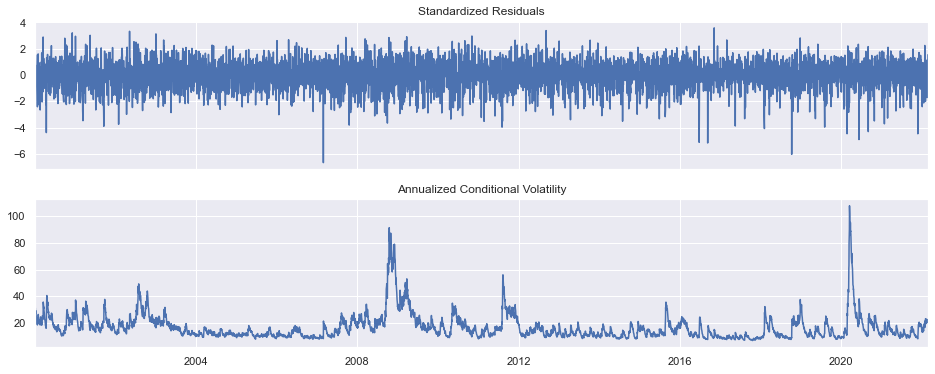

In [50]:
fig=res.plot(annualize='D')

Alternative mean and volatility processes can be directly specified:

In [51]:
am = arch_model(returns, mean='AR', lags=2, vol='harch', p=[1, 5, 22])
res=am.fit() # use option update_freq=5 where 5 is step of output iteration to display
res.summary()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 46463.86659214567
Iteration:      2,   Func. Count:     23,   Neg. LLF: 35352.26070207124
Iteration:      3,   Func. Count:     35,   Neg. LLF: 21911.175733445936
Iteration:      4,   Func. Count:     46,   Neg. LLF: 33711.72510243679
Iteration:      5,   Func. Count:     58,   Neg. LLF: 7794.810301843239
Iteration:      6,   Func. Count:     67,   Neg. LLF: 9016.096588459874
Iteration:      7,   Func. Count:     76,   Neg. LLF: 7672.619776023664
Iteration:      8,   Func. Count:     84,   Neg. LLF: 7933.256043684932
Iteration:      9,   Func. Count:     93,   Neg. LLF: 7888.344643110572
Iteration:     10,   Func. Count:    102,   Neg. LLF: 7643.249146013474
Iteration:     11,   Func. Count:    110,   Neg. LLF: 7643.187678079283
Iteration:     12,   Func. Count:    118,   Neg. LLF: 7643.187133994541
Iteration:     13,   Func. Count:    127,   Neg. LLF: 7643.185886793173
Iteration:     14,   Func. Count:    135,   Neg. LLF: 7643.1858

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - HARCH Model Results                           
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.009
Mean Model:                        AR   Adj. R-squared:                  0.009
Vol Model:                      HARCH   Log-Likelihood:               -7643.19
Distribution:                  Normal   AIC:                           15300.4
Method:            Maximum Likelihood   BIC:                           15346.8
                                        No. Observations:                 5572
Date:                Sat, Feb 26 2022   Df Residuals:                     5569
Time:                        22:30:47   Df Model:                            3
                                   Mean Model                                   
================================================================================
                   coef    std err          t      P>|t|        95.0% Conf. Int.
--------------------------------------------------------------------------------
Const            0.0681  1.111e-02      6.132  8.705e-10   [4.634e-02,8.988e-02]
Adj Close[1]    -0.0633  1.421e-02     -4.457  8.328e-06 [-9.120e-02,-3.548e-02]
Adj Close[2]    -0.0177  1.483e-02     -1.195      0.232  [-4.677e-02,1.134e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1734  2.581e-02      6.718  1.848e-11      [  0.123,  0.224]
alpha[1]       0.0000  2.859e-02      0.000      1.000 [-5.604e-02,5.604e-02]
alpha[5]       0.4432  5.485e-02      8.080  6.471e-16      [  0.336,  0.551]
alpha[22]      0.4362  4.922e-02      8.862  7.842e-19      [  0.340,  0.533]
=============================================================================

Covariance estimator: robust
"""

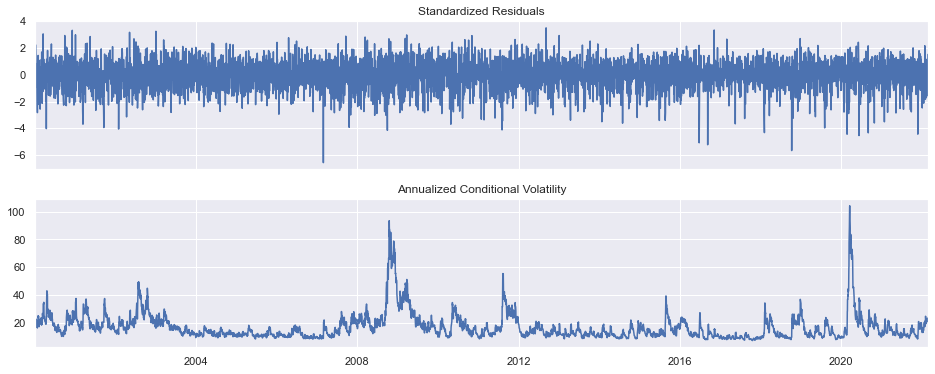

In [52]:
fig=res.plot(annualize='D')

In [53]:
am = arch_model(returns, p=1, o=1, q=1)  # try [dist='StudentsT'] parameter
res = am.fit(update_freq=5, disp='off')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -7536.79
Distribution:                  Normal   AIC:                           15083.6
Method:            Maximum Likelihood   BIC:                           15116.7
                                        No. Observations:                 5574
Date:                Sat, Feb 26 2022   Df Residuals:                     5573
Time:                        22:31:06   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0223  1.064e-02      2.095  3.614e-02 [1.440e-03,4.315e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0226  6.378e-03      3.540  4.003e-04  [1.008e-02,3.508e-02]
alpha[1]   4.5610e-03  1.559e-02      0.293      0.770 [-2.599e-02,3.511e-02]
gamma[1]       0.1837  3.158e-02      5.817  6.004e-09      [  0.122,  0.246]
beta[1]        0.8833  2.543e-02     34.733 2.518e-264      [  0.833,  0.933]
=============================================================================

Covariance estimator: robust
"""

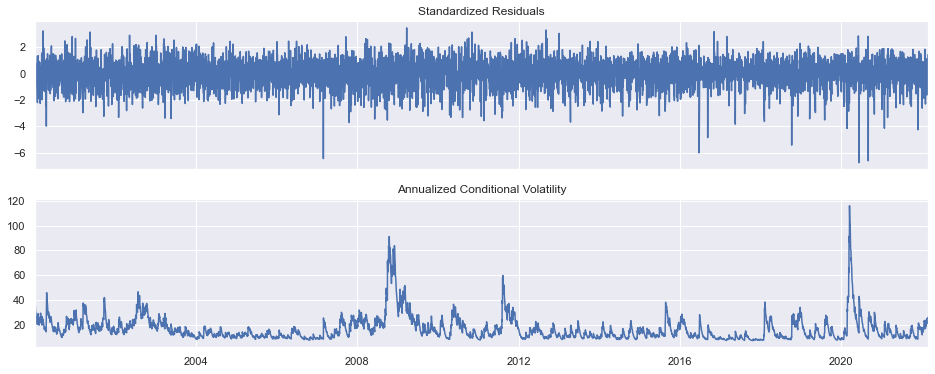

In [54]:
fig=res.plot(annualize='D')

In [55]:
am = arch_model(returns, mean='AR', lags=3, p=1, o=0, q=1, dist='StudentsT')  
res=am.fit()
res.summary() # note how AIC and BIC change when you estimate similar models but use different number of lags

Iteration:      1,   Func. Count:     10,   Neg. LLF: 141431.04486571444
Iteration:      2,   Func. Count:     25,   Neg. LLF: 115514.07030706297
Iteration:      3,   Func. Count:     38,   Neg. LLF: 84413.47518556213
Iteration:      4,   Func. Count:     49,   Neg. LLF: 112009.7759814038
Iteration:      5,   Func. Count:     61,   Neg. LLF: 34437.29389575211
Iteration:      6,   Func. Count:     74,   Neg. LLF: 14613.45450780329
Iteration:      7,   Func. Count:     85,   Neg. LLF: 13297.681130762303
Iteration:      8,   Func. Count:     95,   Neg. LLF: 7549.786847228402
Iteration:      9,   Func. Count:    105,   Neg. LLF: 13111.927758791817
Iteration:     10,   Func. Count:    115,   Neg. LLF: 7505.245209016263
Iteration:     11,   Func. Count:    125,   Neg. LLF: 12360.488063311914
Iteration:     12,   Func. Count:    135,   Neg. LLF: 7499.95301251912
Iteration:     13,   Func. Count:    144,   Neg. LLF: 7501.689789258653
Iteration:     14,   Func. Count:    154,   Neg. LLF: 7500.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                              AR - GARCH Model Results                              
====================================================================================
Dep. Variable:                    Adj Close   R-squared:                       0.008
Mean Model:                              AR   Adj. R-squared:                  0.007
Vol Model:                            GARCH   Log-Likelihood:               -7499.56
Distribution:      Standardized Student's t   AIC:                           15015.1
Method:                  Maximum Likelihood   BIC:                           15068.1
                                              No. Observations:                 5571
Date:                      Sat, Feb 26 2022   Df Residuals:                     5567
Time:                              22:31:14   Df Model:                            4
                                   Mean Model                                   
================================================================================
                   coef    std err          t      P>|t|        95.0% Conf. Int.
--------------------------------------------------------------------------------
Const            0.0875  1.045e-02      8.374  5.567e-17     [6.701e-02,  0.108]
Adj Close[1]    -0.0644  1.284e-02     -5.018  5.234e-07 [-8.960e-02,-3.926e-02]
Adj Close[2]    -0.0324  1.435e-02     -2.260  2.383e-02 [-6.057e-02,-4.305e-03]
Adj Close[3]    -0.0192  1.374e-02     -1.398      0.162  [-4.614e-02,7.716e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0143  3.228e-03      4.429  9.464e-06 [7.970e-03,2.062e-02]
alpha[1]       0.1264  1.210e-02     10.450  1.460e-25     [  0.103,  0.150]
beta[1]        0.8710  1.134e-02     76.838      0.000     [  0.849,  0.893]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             6.1800      0.523     11.812  3.403e-32 [  5.154,  7.205]
========================================================================

Covariance estimator: robust
"""

# Futher readings
- Augmented Dickey-Fuller test document page: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
- On GARCH models (and other volatility models, including ARCH, EGARCH) see https://arch.readthedocs.io/en/latest/univariate/generated/arch.univariate.GARCH.html
- the main method for fitting conditional volatility model is described here: https://arch.readthedocs.io/en/latest/univariate/introduction.html#arch.arch_model
- Another detailed library example is available at http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016. Here, the TSA library is introduced suitable for analysis of ARIMA models.